# BasketBall Data Prediction Using Advanced DeepLearning

**This dataset covers about 30 years of data and has about 400 unique schools. Revealing around 12,000 IDs. Only around 11,000 of those year/team combinations are present, because not every school has a basketball team every year**

## Keras Functional API

**Importing necessary libraries**

In [1]:
import pandas as pd
from pandas import read_csv

import numpy as np
from numpy import unique

from matplotlib import pyplot as plt
from scipy.special import expit as sigmoid

from keras.layers import Input, Dense, Embedding, Flatten
from keras.layers import Subtract, Concatenate
from keras.models import Model
from keras.utils import plot_model

**Read Data File**

In [2]:
games_season = pd.read_csv('DataSet/games_season.csv')
games_season.head()

,season,team_1,team_2,home,score_diff,score_1,score_2,won
0,1985,3745,6664,0,17,81,64,1
1,1985,126,7493,1,7,77,70,1
2,1985,288,3593,1,7,63,56,1
3,1985,1846,9881,1,16,70,54,1
4,1985,2675,10298,1,12,86,74,1


In [3]:
games_tourney = pd.read_csv('DataSet/games_tourney.csv')
games_tourney.head()

,season,team_1,team_2,home,seed_diff,score_diff,score_1,score_2,won
0,1985,288,73,0,-3,-9,41,50,0
1,1985,5929,73,0,4,6,61,55,1
2,1985,9884,73,0,5,-4,59,63,0
3,1985,73,288,0,3,9,50,41,1
4,1985,3920,410,0,1,-9,54,63,0


In [4]:
games_tourney.tail()

,season,team_1,team_2,home,seed_diff,score_diff,score_1,score_2,won
4229,2017,10120,10696,0,-1,-10,74,84,0
4230,2017,320,10818,0,9,-2,71,73,0
4231,2017,2910,10818,0,8,-25,66,91,0
4232,2017,3300,10818,0,10,24,83,59,1
4233,2017,4973,10818,0,5,-11,65,76,0


### Keras Models

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 1)]               0         
_________________________________________________________________
Predicted-Score-Diff (Dense) (None, 1)                 2         
Total params: 2
Trainable params: 2
Non-trainable params: 0
_________________________________________________________________


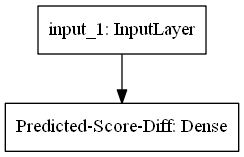

In [5]:
input_tensor = Input(shape=(1,))
output_layer = Dense(1, name='Predicted-Score-Diff')
output_tensor = output_layer(input_tensor)

model = Model(input_tensor, output_tensor)
# should compile the model before fitting it to data
model.compile(optimizer='adam', loss='mae')
model.summary()
plot_model(model, to_file='model.png')

### Plotting Model before fitting

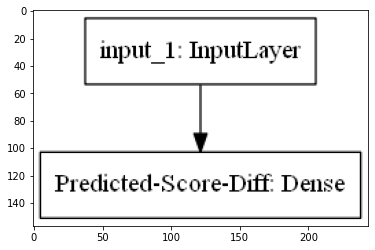

In [6]:
img = plt.imread('model.png')
plt.imshow(img)
plt.show()

### Fit and Evaluate Model

**Goal is to Predict tournament Outcomes**

In [7]:
games = read_csv('DataSet/games_tourney.csv')
model.fit(games['seed_diff'],
          games['score_diff'],
          epochs=1,
          batch_size=128,  # how many rows of data are used for each step of stochastic gradient descent
          # to use a holdout set and return metrics on accuracy using that data
          validation_split=0.10,
          verbose=True)  # prints a log during training

30/30 [==============================] - 0s 16ms/step - loss: 9.5768 - val_loss: 9.1711


**Evaluate Model**

In [8]:
# Load the X variable from the test data
X_test = games['seed_diff']

# Load the y variable from the test data
y_test = games['score_diff']

# Evaluate the model on the test data
print(model.evaluate(X_test, y_test, verbose=False))

9.5145845413208


## Two Input Networks Using Categorical Embeddings, Shared Layers, and Merge Layers

In [9]:
n_teams = unique(games_season['team_1']).shape[0]
n_teams

10888

### Categorical Embeddings

In [10]:
input_tensor = Input(shape=(1,))
n_teams = unique(games_season['team_1']).shape[0]
embed_layer = Embedding(input_dim=n_teams,
                        input_length=1,  # each team represented as a single integer
                        output_dim=1,
                        name='Team-Strength-Lookup')
embed_tensor = embed_layer(input_tensor)
flatten_tensor = Flatten()(embed_tensor)
team_strength_model = Model(input_tensor, flatten_tensor)

### Shared Layers

In [11]:
# Input layer for team 1
team_in_1 = Input(shape=(1,), name='Team-1-In')

# Separate input layer for team 2
team_in_2 = Input(shape=(1,), name='Team-2-In')

# Lookup team 1 in the team strength model
team_1_strength = team_strength_model(team_in_1)

# Lookup team 2 in the team strength model
team_2_strength = team_strength_model(team_in_2)

### Merged Layers

In [12]:
# Create a subtract layer
score_diff = Subtract()([team_1_strength, team_2_strength])

# Create the model
model = Model([team_in_1, team_in_2], score_diff)

# Compile the model
model.compile(optimizer='adam', loss='mean_absolute_error')

**Predict Model**

In [13]:
# Get the team_1 column from the regular season data
input_1 = games_season['team_1']

# Get the team_2 column from the regular season data
input_2 = games_season['team_2']

# Fit the model to input 1 and 2, using score diff as a target
model.fit([input_1, input_2],
          games_season['score_diff'],
          epochs=1,
          batch_size=2048,
          validation_split=0.10,
          verbose=True)

138/138 [==============================] - 1s 7ms/step - loss: 12.1200 - val_loss: 11.8384


*Model has learned strength rating for every team*

**When I evaluated the model on this new dataset. This evaluation basically tells how well one can predict the tournament games, based on a model trained with the regular season data. This is interesting because many teams play each other in the tournament that did not play in the regular season. Performing this check I can now verify that my model is not over fitting.**

In [14]:
# Get team_1 from the tournament data
input_1 = games_tourney['team_1']

# Get team_2 from the tournament data
input_2 = games_tourney['team_2']

# Evaluate the model using these inputs
print(model.evaluate([input_1, input_2],
                     games_tourney['score_diff'], verbose=False))

11.680776596069336


## Multiple Inputs

### Three-Input Models

In [15]:
# Create an Input for each team
team_in_1 = Input(shape=(1,), name='Team-1-In')
team_in_2 = Input(shape=(1,), name='Team-2-In')

# Create an input for home vs away
home_in = Input(shape=(1,), name='Home-In')

# team strength model
team_1_strength = team_strength_model(team_in_1)
team_2_strength = team_strength_model(team_in_2)

# Combine the team strengths with the home input
out = Concatenate()([team_1_strength, team_2_strength, home_in])
out = Dense(1)(out)

In [16]:
model = Model([team_in_1, team_in_2, home_in], out)
model.compile(optimizer='adam', loss='mean_absolute_error')

In [17]:
# Fit the model to the games_season dataset
model.fit([games_season['team_1'], games_season['team_2'], games_season['home']],
          games_season['score_diff'],
          epochs=1,
          verbose=True,
          validation_split=.10,
          batch_size=2048)

# Evaluate the model on the games_tourney dataset
print(model.evaluate([games_tourney['team_1'], games_tourney['team_2'], games_tourney['home']],
                     games_tourney['score_diff'], verbose=False))

138/138 [==============================] - 1s 7ms/step - loss: 12.1043 - val_loss: 12.1220
11.685766220092773


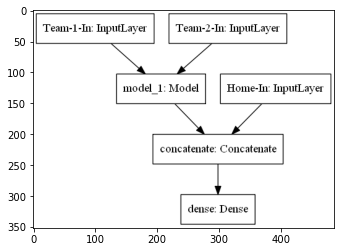

In [18]:
# Plot the model
plot_model(model, to_file='model1.png')

# Display the image
data = plt.imread('model1.png')
plt.imshow(data)
plt.show()

### Model Stacking

*Here I tried to improve the model by using a form of model stacking by utilizing prediction from the regular season model as an input to the tournament model.*

In [19]:
games_tourney['pred'] = model.predict([games_tourney['team_1'],
                                       games_tourney['team_2'],
                                       games_tourney['home']])

In [20]:
games_tourney_train = games_tourney[[
    'home', 'seed_diff', 'score_1', 'score_2', 'score_diff', 'won', 'pred']]
games_tourney_test = games_tourney[[
    'home', 'seed_diff', 'score_1', 'score_2', 'score_diff', 'won', 'pred']]

In [21]:
# Input layer with 3 columns
input_tensor = Input((3,))

# Pass it to Dense layer with 1 unit
output_tensor = Dense(1)(input_tensor)

# Model
model = Model(input_tensor, output_tensor)

# Compile
model.compile(optimizer='adam', loss='mean_absolute_error')

train_X = games_tourney_train[['home', 'seed_diff', 'pred']]
train_y = games_tourney_train['score_diff']


model.fit(train_X,
          train_y,
          epochs=10,
          validation_split=0.10,
          verbose=True)

Epoch 1/10
120/120 [==============================] - 0s 3ms/step - loss: 14.2432 - val_loss: 13.7787
Epoch 2/10
120/120 [==============================] - 0s 2ms/step - loss: 13.7142 - val_loss: 13.2697
Epoch 3/10
120/120 [==============================] - 0s 3ms/step - loss: 13.2104 - val_loss: 12.7809
Epoch 4/10
120/120 [==============================] - 0s 3ms/step - loss: 12.7358 - val_loss: 12.3175
Epoch 5/10
120/120 [==============================] - 0s 3ms/step - loss: 12.3018 - val_loss: 11.8884
Epoch 6/10
120/120 [==============================] - 0s 4ms/step - loss: 11.8923 - val_loss: 11.4878
Epoch 7/10
120/120 [==============================] - 0s 4ms/step - loss: 11.4941 - val_loss: 11.0931
Epoch 8/10
120/120 [==============================] - 0s 3ms/step - loss: 11.1217 - val_loss: 10.7238
Epoch 9/10
120/120 [==============================] - 0s 3ms/step - loss: 10.7864 - val_loss: 10.3893
Epoch 10/10
120/120 [==============================] - 0s 4ms/step - loss: 10.4904

In [22]:
test_X = games_tourney_test[['home', 'seed_diff', 'pred']]
test_y = games_tourney_test['score_diff']
model.evaluate(test_X, test_y, verbose=False)

10.32840347290039

## Multiple Outputs

### Two-Output Models

In [23]:
# Define the input
input_tensor = Input(shape=(2,))

# Define the output
output_tensor = Dense(2)(input_tensor)

# Create a model
model = Model(input_tensor, output_tensor)

# Compile the model
model.compile(optimizer='adam', loss='mean_absolute_error')

In [24]:
model.fit(games_tourney_train[['seed_diff', 'pred']],
          games_tourney_train[['score_1', 'score_2']],
          verbose=True,
          epochs=100,
          batch_size=16384)

Epoch 1/100
1/1 [==============================] - 0s 2ms/step - loss: 71.0647
Epoch 2/100
1/1 [==============================] - 0s 997us/step - loss: 71.0634
Epoch 3/100
1/1 [==============================] - 0s 996us/step - loss: 71.0622
Epoch 4/100
1/1 [==============================] - 0s 997us/step - loss: 71.0610
Epoch 5/100
1/1 [==============================] - 0s 999us/step - loss: 71.0598
Epoch 6/100
1/1 [==============================] - 0s 0s/step - loss: 71.0585
Epoch 7/100
1/1 [==============================] - 0s 998us/step - loss: 71.0573
Epoch 8/100
1/1 [==============================] - 0s 994us/step - loss: 71.0561
Epoch 9/100
1/1 [==============================] - 0s 997us/step - loss: 71.0549
Epoch 10/100
1/1 [==============================] - 0s 0s/step - loss: 71.0536
Epoch 11/100
1/1 [==============================] - 0s 1ms/step - loss: 71.0524
Epoch 12/100
1/1 [==============================] - 0s 997us/step - loss: 71.0512
Epoch 13/100
1/1 [=================

In [25]:
# Model's weights
print(model.get_weights())

# Column means of the training data
print(games_tourney.mean())

[array([[-0.5512995 ,  1.1610199 ],
       [ 0.6628754 ,  0.12013929]], dtype=float32), array([0.09999996, 0.09999996], dtype=float32)]
season        2001.193198
team_1        5589.146906
team_2        5589.146906
home             0.000000
seed_diff        0.000000
score_diff       0.000000
score_1         71.131318
score_2         71.131318
won              0.500000
pred             0.228627
dtype: float64


**It can be noticed that both output weights are about ~72. This is because, on average, a team will score about 72 points in the tournament.**

In [26]:
print(model.evaluate(games_tourney_test[['seed_diff', 'pred']],
                     games_tourney_test[['score_1', 'score_2']], verbose=False))

70.94181060791016


### Single Model for Classification and regression

In [27]:
# Create an input layer with 2 columns
input_tensor = Input(shape=(2,))

# Create the first output
output_tensor_1 = Dense(1, activation='linear', use_bias=False)(input_tensor)

# Create the second output (use the first output as input here)
output_tensor_2 = Dense(1, activation='sigmoid',
                        use_bias=False)(output_tensor_1)

# Create a model with 2 outputs
model = Model(input_tensor, [output_tensor_1, output_tensor_2])

In [28]:
# Import the Adam optimizer
from keras.optimizers import Adam

# Compile the model with 2 losses and the Adam optimzer with a higher learning rate
model.compile(loss=['mean_absolute_error',
                    'binary_crossentropy'], optimizer=Adam(.01))

# Fit the model to the tournament training data, with 2 inputs and 2 outputs
model.fit(games_tourney_train[['seed_diff', 'pred']],
          [games_tourney_train[['score_diff']], games_tourney_train[['won']]],
          epochs=500,
          verbose=True,
          batch_size=16384)

Epoch 1/500
1/1 [==============================] - 0s 4ms/step - loss: 16.0664 - dense_3_loss: 13.8466 - dense_4_loss: 2.2198
Epoch 2/500
1/1 [==============================] - 0s 4ms/step - loss: 15.9613 - dense_3_loss: 13.8012 - dense_4_loss: 2.1600
Epoch 3/500
1/1 [==============================] - 0s 4ms/step - loss: 15.8573 - dense_3_loss: 13.7559 - dense_4_loss: 2.1015
Epoch 4/500
1/1 [==============================] - 0s 3ms/step - loss: 15.7547 - dense_3_loss: 13.7106 - dense_4_loss: 2.0441
Epoch 5/500
1/1 [==============================] - 0s 5ms/step - loss: 15.6533 - dense_3_loss: 13.6653 - dense_4_loss: 1.9880
Epoch 6/500
1/1 [==============================] - 0s 3ms/step - loss: 15.5534 - dense_3_loss: 13.6201 - dense_4_loss: 1.9332
Epoch 7/500
1/1 [==============================] - 0s 3ms/step - loss: 15.4551 - dense_3_loss: 13.5754 - dense_4_loss: 1.8797
Epoch 8/500
1/1 [==============================] - 0s 3ms/step - loss: 15.3584 - dense_3_loss: 13.5308 - dense_4_loss:

1/1 [==============================] - 0s 2ms/step - loss: 12.1337 - dense_3_loss: 11.4774 - dense_4_loss: 0.6563
Epoch 66/500
1/1 [==============================] - 0s 1ms/step - loss: 12.1000 - dense_3_loss: 11.4483 - dense_4_loss: 0.6517
Epoch 67/500
1/1 [==============================] - 0s 998us/step - loss: 12.0666 - dense_3_loss: 11.4193 - dense_4_loss: 0.6473
Epoch 68/500
1/1 [==============================] - 0s 2ms/step - loss: 12.0334 - dense_3_loss: 11.3905 - dense_4_loss: 0.6430
Epoch 69/500
1/1 [==============================] - 0s 998us/step - loss: 12.0007 - dense_3_loss: 11.3619 - dense_4_loss: 0.6388
Epoch 70/500
1/1 [==============================] - 0s 997us/step - loss: 11.9682 - dense_3_loss: 11.3335 - dense_4_loss: 0.6347
Epoch 71/500
1/1 [==============================] - 0s 2ms/step - loss: 11.9360 - dense_3_loss: 11.3053 - dense_4_loss: 0.6307
Epoch 72/500
1/1 [==============================] - 0s 997us/step - loss: 11.9041 - dense_3_loss: 11.2773 - dense_4_lo

1/1 [==============================] - 0s 6ms/step - loss: 10.6300 - dense_3_loss: 10.0714 - dense_4_loss: 0.5586
Epoch 130/500
1/1 [==============================] - 0s 3ms/step - loss: 10.6162 - dense_3_loss: 10.0572 - dense_4_loss: 0.5591
Epoch 131/500
1/1 [==============================] - 0s 4ms/step - loss: 10.6028 - dense_3_loss: 10.0432 - dense_4_loss: 0.5596
Epoch 132/500
1/1 [==============================] - 0s 4ms/step - loss: 10.5896 - dense_3_loss: 10.0295 - dense_4_loss: 0.5601
Epoch 133/500
1/1 [==============================] - 0s 7ms/step - loss: 10.5766 - dense_3_loss: 10.0160 - dense_4_loss: 0.5606
Epoch 134/500
1/1 [==============================] - 0s 4ms/step - loss: 10.5638 - dense_3_loss: 10.0026 - dense_4_loss: 0.5612
Epoch 135/500
1/1 [==============================] - 0s 5ms/step - loss: 10.5510 - dense_3_loss: 9.9893 - dense_4_loss: 0.5617
Epoch 136/500
1/1 [==============================] - 0s 4ms/step - loss: 10.5383 - dense_3_loss: 9.9761 - dense_4_loss:

1/1 [==============================] - 0s 3ms/step - loss: 10.0078 - dense_3_loss: 9.4516 - dense_4_loss: 0.5562
Epoch 194/500
1/1 [==============================] - 0s 3ms/step - loss: 10.0015 - dense_3_loss: 9.4456 - dense_4_loss: 0.5559
Epoch 195/500
1/1 [==============================] - 0s 7ms/step - loss: 9.9953 - dense_3_loss: 9.4396 - dense_4_loss: 0.5557
Epoch 196/500
1/1 [==============================] - 0s 6ms/step - loss: 9.9891 - dense_3_loss: 9.4337 - dense_4_loss: 0.5554
Epoch 197/500
1/1 [==============================] - 0s 4ms/step - loss: 9.9831 - dense_3_loss: 9.4279 - dense_4_loss: 0.5552
Epoch 198/500
1/1 [==============================] - 0s 8ms/step - loss: 9.9771 - dense_3_loss: 9.4221 - dense_4_loss: 0.5550
Epoch 199/500
1/1 [==============================] - 0s 3ms/step - loss: 9.9711 - dense_3_loss: 9.4163 - dense_4_loss: 0.5548
Epoch 200/500
1/1 [==============================] - 0s 7ms/step - loss: 9.9652 - dense_3_loss: 9.4106 - dense_4_loss: 0.5546
Epoc

1/1 [==============================] - 0s 3ms/step - loss: 9.7523 - dense_3_loss: 9.1993 - dense_4_loss: 0.5529
Epoch 259/500
1/1 [==============================] - 0s 5ms/step - loss: 9.7505 - dense_3_loss: 9.1976 - dense_4_loss: 0.5529
Epoch 260/500
1/1 [==============================] - 0s 3ms/step - loss: 9.7491 - dense_3_loss: 9.1962 - dense_4_loss: 0.5529
Epoch 261/500
1/1 [==============================] - 0s 4ms/step - loss: 9.7478 - dense_3_loss: 9.1949 - dense_4_loss: 0.5529
Epoch 262/500
1/1 [==============================] - 0s 6ms/step - loss: 9.7466 - dense_3_loss: 9.1937 - dense_4_loss: 0.5529
Epoch 263/500
1/1 [==============================] - 0s 3ms/step - loss: 9.7456 - dense_3_loss: 9.1927 - dense_4_loss: 0.5529
Epoch 264/500
1/1 [==============================] - 0s 5ms/step - loss: 9.7445 - dense_3_loss: 9.1916 - dense_4_loss: 0.5529
Epoch 265/500
1/1 [==============================] - 0s 6ms/step - loss: 9.7435 - dense_3_loss: 9.1906 - dense_4_loss: 0.5529
Epoch 

1/1 [==============================] - 0s 5ms/step - loss: 9.7075 - dense_3_loss: 9.1546 - dense_4_loss: 0.5529
Epoch 324/500
1/1 [==============================] - 0s 4ms/step - loss: 9.7071 - dense_3_loss: 9.1542 - dense_4_loss: 0.5529
Epoch 325/500
1/1 [==============================] - 0s 6ms/step - loss: 9.7068 - dense_3_loss: 9.1539 - dense_4_loss: 0.5529
Epoch 326/500
1/1 [==============================] - 0s 7ms/step - loss: 9.7064 - dense_3_loss: 9.1536 - dense_4_loss: 0.5529
Epoch 327/500
1/1 [==============================] - 0s 7ms/step - loss: 9.7061 - dense_3_loss: 9.1532 - dense_4_loss: 0.5529
Epoch 328/500
1/1 [==============================] - 0s 5ms/step - loss: 9.7058 - dense_3_loss: 9.1530 - dense_4_loss: 0.5529
Epoch 329/500
1/1 [==============================] - 0s 4ms/step - loss: 9.7055 - dense_3_loss: 9.1527 - dense_4_loss: 0.5529
Epoch 330/500
1/1 [==============================] - 0s 5ms/step - loss: 9.7053 - dense_3_loss: 9.1524 - dense_4_loss: 0.5529
Epoch 

1/1 [==============================] - 0s 5ms/step - loss: 9.6974 - dense_3_loss: 9.1446 - dense_4_loss: 0.5529
Epoch 389/500
1/1 [==============================] - 0s 4ms/step - loss: 9.6974 - dense_3_loss: 9.1445 - dense_4_loss: 0.5529
Epoch 390/500
1/1 [==============================] - 0s 5ms/step - loss: 9.6974 - dense_3_loss: 9.1445 - dense_4_loss: 0.5529
Epoch 391/500
1/1 [==============================] - 0s 5ms/step - loss: 9.6974 - dense_3_loss: 9.1445 - dense_4_loss: 0.5529
Epoch 392/500
1/1 [==============================] - 0s 6ms/step - loss: 9.6973 - dense_3_loss: 9.1445 - dense_4_loss: 0.5529
Epoch 393/500
1/1 [==============================] - 0s 4ms/step - loss: 9.6973 - dense_3_loss: 9.1444 - dense_4_loss: 0.5529
Epoch 394/500
1/1 [==============================] - 0s 4ms/step - loss: 9.6973 - dense_3_loss: 9.1444 - dense_4_loss: 0.5529
Epoch 395/500
1/1 [==============================] - 0s 4ms/step - loss: 9.6973 - dense_3_loss: 9.1444 - dense_4_loss: 0.5529
Epoch 

1/1 [==============================] - 0s 5ms/step - loss: 9.6969 - dense_3_loss: 9.1441 - dense_4_loss: 0.5529
Epoch 454/500
1/1 [==============================] - 0s 3ms/step - loss: 9.6969 - dense_3_loss: 9.1441 - dense_4_loss: 0.5529
Epoch 455/500
1/1 [==============================] - 0s 8ms/step - loss: 9.6969 - dense_3_loss: 9.1441 - dense_4_loss: 0.5529
Epoch 456/500
1/1 [==============================] - 0s 3ms/step - loss: 9.6969 - dense_3_loss: 9.1441 - dense_4_loss: 0.5529
Epoch 457/500
1/1 [==============================] - 0s 3ms/step - loss: 9.6969 - dense_3_loss: 9.1441 - dense_4_loss: 0.5529
Epoch 458/500
1/1 [==============================] - 0s 4ms/step - loss: 9.6969 - dense_3_loss: 9.1441 - dense_4_loss: 0.5529
Epoch 459/500
1/1 [==============================] - 0s 4ms/step - loss: 9.6969 - dense_3_loss: 9.1441 - dense_4_loss: 0.5529
Epoch 460/500
1/1 [==============================] - 0s 7ms/step - loss: 9.6969 - dense_3_loss: 9.1441 - dense_4_loss: 0.5529
Epoch 

In [29]:
# Print the model weights
print(model.get_weights())

# Print the training data means
print(games_tourney_train.mean())

[array([[1.1635586 ],
       [0.40233317]], dtype=float32), array([[0.14426836]], dtype=float32)]
home           0.000000
seed_diff      0.000000
score_1       71.131318
score_2       71.131318
score_diff     0.000000
won            0.500000
pred           0.228627
dtype: float64


In [30]:
# Weight from the model
weight = 0.14

# Print the approximate win probability of a predicted close game
print(sigmoid(1 * weight))

# Print the approximate win probability of a predicted blowout game
print(sigmoid(10 * weight))

0.5349429451582145
0.8021838885585818


In [31]:
print(model.evaluate(games_tourney_test[['seed_diff', 'pred']],
                     [games_tourney_test[['score_diff']], games_tourney_test[['won']]], verbose=False))

[9.696845054626465, 9.143974304199219, 0.5528696179389954]


## Conclusion

* 9.7 = Loss function used by the model, which is sum of all output losses


* 9.14 = Loss for regression part of the model, Therefore, this model has a mean absolute error of 9.14


* 0.55 = Loss for classification part of the model, Logloss of 0.58